# Import package

In [1]:
import h5py
import numpy as np
f = h5py.File('./sst_weekly.mat','r')
lat = np.array(f['lat'])
lon = np.array(f['lon'])
sst_all = np.array(f['sst'])
time = np.array(f['time'])

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from Sample import *
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vision_transformer as vit

c:\Users\25422\anaconda3\envs\speit\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Create the source map, target map, detector map

In [45]:
sst = sst_all[0]
sst_obj = SST(lat, lon, sst, time, 10, 500)
target, source, source_map = sst_obj.get_trainer()

In [40]:
target0 = torch.from_numpy(target.copy())
target0 = target0.unsqueeze(0).unsqueeze(0)
target0.shape

torch.Size([1, 1, 180, 360])

In [46]:
source = torch.from_numpy(expand(source).copy()).unsqueeze(0).unsqueeze(0).to(torch.float32).repeat(1,3,1,1).to(device)

In [47]:
output = model(source)

In [52]:
output.view(360,360)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward0>)

In [23]:
def data_geneator(lat, lon, time, sst_all, batch_size):
    sensor_num = [10, 15, 20, 25,30]
    sensor_seed = [1, 10, 25, 51, 199]
    for i in range(batch_size):
        for j in sensor_num:
            for k in sensor_seed:
                sst = sst_all[i]
                sst_obj = SST(lat, lon, sst, time, j, k)
                target, source, source_map = sst_obj.get_trainer()
                target = torch.from_numpy(expand(target).copy()).unsqueeze(0).unsqueeze(0)
                source = torch.from_numpy(expand(source).copy()).unsqueeze(0).unsqueeze(0)
                source_map = torch.from_numpy(expand(source_map).copy()).unsqueeze(0).unsqueeze(0)
                yield (target, source, source_map)

In [56]:
from tqdm import tqdm
def train(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for target, source, source_map in tqdm(data_loader):
        batch_input = source.to(torch.float32).repeat(1,3,1,1).to(device)
        batch_target = target.to(torch.float32).repeat(1,3,1,1).to(device)
        optimizer.zero_grad()
        output = model(batch_input)
        output = output.view(360,360)
        loss = criterion(output, batch_target[0][0])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

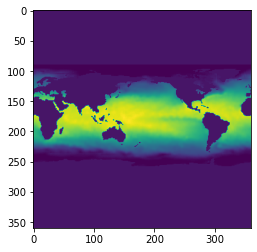

In [16]:
target_expand = expand(target)
plt.imshow(target_expand)

# Create a model with VIT

In [6]:
model = vit.VisionTransformer(image_size=360,
    patch_size=18,
    num_layers=24,
    num_heads=16,
    hidden_dim=1024,
    mlp_dim=4096,
    num_classes=360*360)

In [21]:
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(18, 18), stride=(18, 18))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

In [58]:
data_loader = data_geneator(lat, lon, time, sst_all, 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [59]:
data_loader = data_geneator(lat, lon, time, sst_all, 1)
train(model, data_loader, optimizer, criterion, device)

25it [02:37,  6.28s/it]


3.418156024068594

In [60]:
sst = sst_all[0]
sst_obj = SST(lat, lon, sst, time, 10, 500)
target, source, source_map = sst_obj.get_trainer()
source_test = torch.from_numpy(expand(source).copy()).unsqueeze(0).unsqueeze(0).to(torch.float32).repeat(1,3,1,1).to(device)

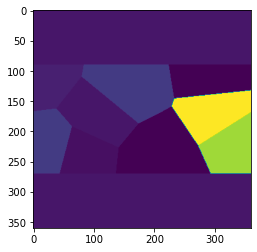

In [61]:
source_expand = expand(source)
target_expand = expand(target)
plt.imshow(source_expand)

In [76]:
torch.save(model.state_dict(), "./vit_sst.pth")

In [ ]:
model = vit.VisionTransformer(image_size=360,
    patch_size=18,
    num_layers=24,
    num_heads=16,
    hidden_dim=1024,
    mlp_dim=4096,
    num_classes=360*360)
model.load_state_dict(torch.load("./vit_sst.pth"))
model.eval()

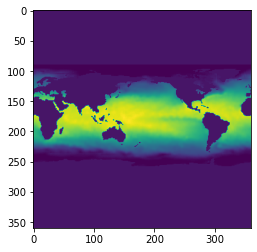

In [62]:
plt.imshow(target_expand)

In [63]:
target_test = model(source_test)

In [73]:
# target_test = target_test.detach().numpy()
target_test = target_test.reshape(360,360)

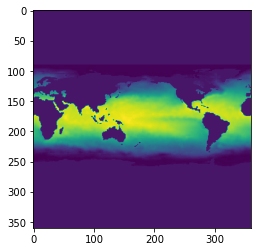

In [74]:
plt.imshow(target_test)

# Test Session

### Generate a model and prepare the training data

In [1]:
import numpy as np

In [3]:
import h5py
import numpy as np
f = h5py.File('./sst_weekly.mat','r')
lat = np.array(f['lat'])
lon = np.array(f['lon'])
sst_all = np.array(f['sst'])
time = np.array(f['time'])

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from Sample import *
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vision_transformer as vit

In [6]:
model = vit.VisionTransformer(image_size=360,
    patch_size=18,
    num_layers=24,
    num_heads=16,
    hidden_dim=512,
    mlp_dim=2048,
    num_classes=180*360)

# model.load_state_dict(torch.load("./vit_sst_small.pth"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [14]:
torch.cuda.empty_cache()

In [8]:
data_loader = data_geneator(lat, lon, time, sst_all, batch_size = 20, device = device, start_point = 10)
train(model, data_loader, optimizer, criterion, device)

500it [00:55,  9.07it/s]


3900.134457212407

### View the output

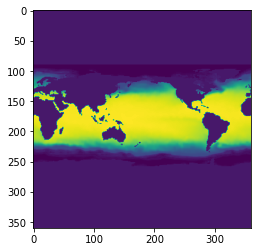

In [7]:
n = 1048 # The number of map you want to test
sensor_num = 15
sensor_seed = 500
sst = sst_all[n]
sst_obj = SST(lat, lon, sst, time, sensor_num, sensor_seed)
target, source, source_map = sst_obj.get_trainer()
source_test = to_input(source, device)
target_test = model(source_test)
target_test = target_test.detach().numpy()
target_test = target_test.reshape(360,360)
plt.imshow(target_test)

In [29]:
sensor_num = 15
sensor_seed = 500
sst = sst_all[500]
sst_obj = SST(lat, lon, sst, time, sensor_num, sensor_seed)
target, source, source_map = sst_obj.get_trainer()

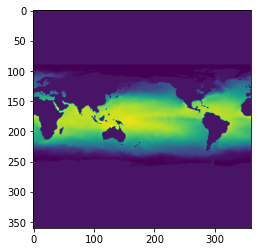

In [9]:
plt.imshow(expand(target))

In [14]:
criterion(torch.from_numpy(target_test), torch.from_numpy(expand(target)))

tensor(3.3503, dtype=torch.float64)

### Test for trained and unseen positions

In [31]:
model.load_state_dict(torch.load("./vit_sst_small.pth"))

<All keys matched successfully>

In [5]:
# Trained positions
sensornum = [10, 20, 30, 50, 100]
for i in range(5):
    data_loader = data_geneator(lat, lon, time, sst_all, batch_size = 10, device = device, start_point = 0, sensor_num = [sensornum[i]])
    error, test_number = test(model, data_loader, criterion, device)
    print(torch.sqrt(error)/test_number)

50it [00:04, 10.36it/s]


tensor(0.0103, device='cuda:0')


50it [00:01, 42.64it/s]


tensor(0.0103, device='cuda:0')


50it [00:01, 39.36it/s]


tensor(0.0103, device='cuda:0')


50it [00:01, 39.85it/s]


tensor(0.0103, device='cuda:0')


50it [00:01, 38.66it/s]

tensor(0.0103, device='cuda:0')


In [11]:
# Unseen positions
sensornum = [10, 20, 30, 50, 70, 100, 200]
sensorseed = [4, 20, 75, 138, 278]
for i in range(7):
    data_loader = data_geneator(lat, lon, time, sst_all, batch_size = 1, start_point = 128, sensor_num = [sensornum[i]], sensor_seed = sensorseed)
    total_loss, test_number =  test(model, data_loader, criterion, device)
    print(total_loss/test_number)

5it [00:07,  1.53s/it]


0.8707589983940125


5it [00:07,  1.58s/it]


0.8709354162216186


5it [00:07,  1.57s/it]


0.8709182977676392


5it [00:07,  1.56s/it]


0.8709469556808471


5it [00:07,  1.58s/it]


0.8709473609924316


5it [00:07,  1.58s/it]


0.8709303736686707


5it [00:07,  1.48s/it]

0.8709301352500916


In [ ]:
data_loader = data_geneator(lat, lon, time, sst_all, 1, start_point = 1)
test(model, data_loader,criterion, device)

### Save the model

In [34]:
torch.save(model.state_dict(), "./vit_sst_small.pth")

# Brouillon

In [10]:
lat.shape # (1,180)，纬度
lon.shape # (1,360)，经度
sst.shape # (1914,64800)
time.shape # (1,1914)

(1914, 64800)

In [14]:
time

array([[66410., 66417., 66424., ..., 79783., 79790., 79797.]])

In [16]:
sen_num_kind = 5
sen_num_var = 5
X_ki = np.zeros((1040*sen_num_kind*sen_num_var,len(lat[0,:]),len(lon[0,:]),2))
y_ki = np.zeros((1040*sen_num_kind*sen_num_var,len(lat[0,:]),len(lon[0,:]),1))

In [21]:
X_ki.shape, y_ki.shape

((26000, 180, 360, 2), (26000, 180, 360, 1))

In [20]:
sst_reshape = sst[0,:].reshape(len(lat[0,:]),len(lon[0,:]),order='F')
sst_reshape.shape

(180, 360)

In [22]:
xv1, yv1 =np.meshgrid(lon[0,:],lat[0,:])

In [24]:
yv1

array([[ 89.5,  89.5,  89.5, ...,  89.5,  89.5,  89.5],
       [ 88.5,  88.5,  88.5, ...,  88.5,  88.5,  88.5],
       [ 87.5,  87.5,  87.5, ...,  87.5,  87.5,  87.5],
       ...,
       [-87.5, -87.5, -87.5, ..., -87.5, -87.5, -87.5],
       [-88.5, -88.5, -88.5, ..., -88.5, -88.5, -88.5],
       [-89.5, -89.5, -89.5, ..., -89.5, -89.5, -89.5]], dtype=float32)